# text exploration

- statistics
    - length, etc.
- cleaning
- reduce data
    - consider taking only x first sentences
- pca
- stemming
- tokenizing
- implement tf-idf 

In [45]:
import re
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from utils.read_data import read_articles_file

In [2]:
def remove_numbers(string:str):
    pattern = r'[0-9]'

    # Match all digits in the string and replace them with an empty string
    new_string = re.sub(pattern, '', string)
    return new_string

In [3]:
article_texts_path = "/work3/s204163/wiki/article_texts"
article_ids_path = "/work3/s204163/wiki/article_ids"

N = 1000
articles = read_articles_file(article_texts_path, return_titles = False)

In [4]:
# TODO: make nicer
arts = {}

keys = random.sample(list(articles.keys()), N)
for key in keys:
    arts[key] = articles[key]

articles = arts
print(len(articles))

1000


In [5]:
corpus = [0] * N
lens = [0] * N

for i, (id, text) in enumerate(articles.items()):
    corpus[i] = text
    lens[i] = len(text)

# TF-IDF

In [44]:
vectorizer = TfidfVectorizer(max_features=200)

In [47]:
X = vectorizer.fit_transform(corpus)

print(X.shape)

(1000, 200)


# Clustering

In [62]:
kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(X)
labels = kmeans.labels_
print(labels[:40])

[ 3  0 18 11 16 12  4 12  6 16  9  3 15 11  9 15 13  3  1  0 19  2 19 18
  9  5 11  1  8 16  2 10  6  8 16  5 16 16  2  8]


In [63]:
for i, (text, label) in enumerate(zip(corpus, labels)):
    if label == 1:
        print(text[:200])
        print(" ")

"Nobody Sees" is a song by Powderfinger from their sixth album Dream Days at the Hotel Existence. It is the third single from the album and was released in Australia on 1 December 2007. The announceme
 
"Sexy! No No No..." is a song by British girl group Girls Aloud from their fourth studio album, Tangled Up (2007). In 2007, the group announced that they would release a new album, due in November of 
 
"Hold It Against Me" is a song performed by American singer Britney Spears for her seventh studio album, Femme Fatale (2011). It was written and produced by Max Martin, Dr. Luke and Billboard, with ad
 
Bleach is the debut studio album by the American rock band Nirvana, released on June 15, 1989 by Sub Pop. The main recording sessions took place at Reciprocal Recording in Seattle, Washington between 
 
Madonna (retitled Madonna: The First Album for the 1985 re-release) is the debut album by American singer Madonna, released on July 27, 1983 by Sire Records. After having established herse

# PCA

In [52]:
pca = PCA(n_components=2)

X = pca.fit(X.toarray()).transform(X.toarray())

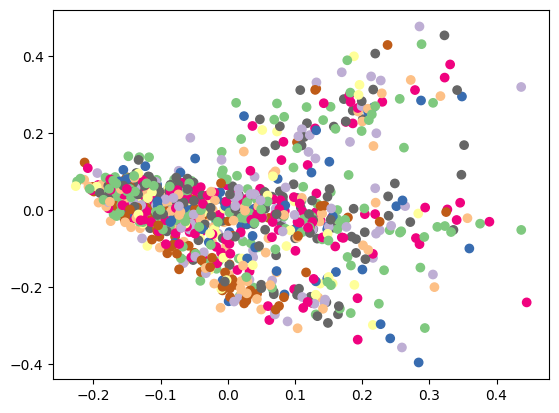

In [59]:
x, y = X.T
plt.scatter(x, y, c = labels, cmap="Accent")